# ARIMA para pedição de preço de ações

Realizei este projeto com o objetivo de consolidar e aprimorar meus conhecimentos em predições de séries temporais.

Para tal, utilizei a metodologia ARIMA (Autoregressive Integrated Moving Average), aplicado à dados dos preços do ETV BOVA11, que representa um portfólio composto pelas maiores empresas da bolsa brasileira.

O objetivo do estudo é gerar um modelo capaz de prever a variação no preço do ETF.

O modeloa ARIMA depende de 3 critérios (*p*, *d* e *q*), que serão abordados e encontrados ao longo do texto:

- p: a ordem do modelo autorregressor (AR)
- d: número de diferenciações necessárias para a série se tornar estacionária.
- d: ordem do modelo MA

## Preparando o ambiente

Inicialmente serão importadas as bibliotecas e base de dados utilizadas no projeto.

In [1]:
# Importando bibliotecas

import pandas as pd
import numpy as np

import plotly.express as px

import matplotlib.pyplot as plt

import yfinance as yf

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

Para o estudo, serão usadas as séries referentes ao preço diários do ticker BOVA11 entre 2008 e 2022, adquiridos através do yahoo finance.

Na base de dados (abaixo), podemos observar diferentes preços. Será utilizado o preço de fechamento ('Close') do dia.

A série foi dividida entre base de dados de teste (20%) e de trainamento (80%).

In [2]:
tick = yf.Ticker('BOVA11.SA')

bova11 = tick.history(period='max')

bova11

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2008-11-28 00:00:00-02:00,36.595901,36.595901,36.595901,36.595901,0,0,0
2008-12-01 00:00:00-02:00,34.744900,34.744900,34.744900,34.744900,0,0,0
2008-12-02 00:00:00-02:00,35.001598,35.001598,35.001598,35.001598,0,0,0
2008-12-03 00:00:00-02:00,35.293800,35.293800,35.293800,35.293800,0,0,0
2008-12-04 00:00:00-02:00,35.122101,35.122101,35.122101,35.122101,0,0,0
...,...,...,...,...,...,...,...
2022-10-14 00:00:00-03:00,110.360001,110.720001,107.669998,108.220001,6057935,0,0
2022-10-17 00:00:00-03:00,108.769997,110.389999,108.410004,109.900002,4177222,0,0
2022-10-18 00:00:00-03:00,111.250000,111.940002,110.180000,111.940002,6795170,0,0


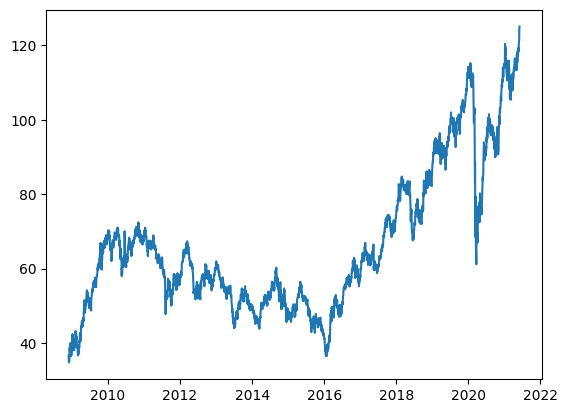

In [3]:
serie = bova11['Close']

train, test = serie.iloc[:int(len(serie)*0.9)], serie.iloc[int(len(serie)*0.9):]

plt.plot(train)

## Estacionariedade da Série

Para se trabalhar com séries temporais, é necessário que as séries sejam estacionárias. A estacionariedade é definida por 3 características:
- Não possui tendência
- Possui variância constante
- Autocorrelação entre as variáveis não muda com tempo

O gráfico plotado abaixo traz uma decomposição da série, onde é possível separar os componentes de tendência, sazonalidade e erro. À princípio, observando a imagem, não parece que a série siga os critérios de estacionariedade.

Para uma melhor visualização da existência de tendência, é possível realizar uma decomposição entre tendencia, sazonalidade e erro.

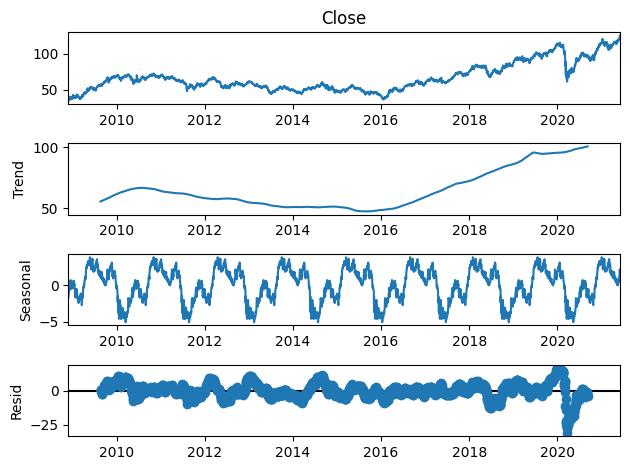

In [4]:
decomposed_ibov_close = sm.tsa.seasonal_decompose(train,period=360) # The frequncy is annual
figure = decomposed_ibov_close.plot()
plt.show()

Para validar essa constatação com base no gráfico, podemos usar um teste de estacionariedade.

Neste projeto, optei pelo uso do teste Dickey-Fuller aumentado, que testa a hipótese nula de que a série possui uma raiz unitária (a = 1). Caso a hipótese nula seja rejeitada, pode-se consluir que a série é estacionária.

In [5]:
print('ADF Test Statistics:', adfuller(train)[0])
print('ADF P-value:', adfuller(train)[1])

ADF Test Statistics: -0.738380695639715
ADF P-value: 0.8365560780053627


O p-valor do teste é de 0.623, superior ao nível de significância (0.05). Nesse caso, não podemos rejeitar a hipótese de raiz unitária.

Uma possível solução para lidar com uma série não estacionária é a realização da diferenciação dos valores. Ou seja, calcular a diferença $t_{0}$ - $t_{-1}$.

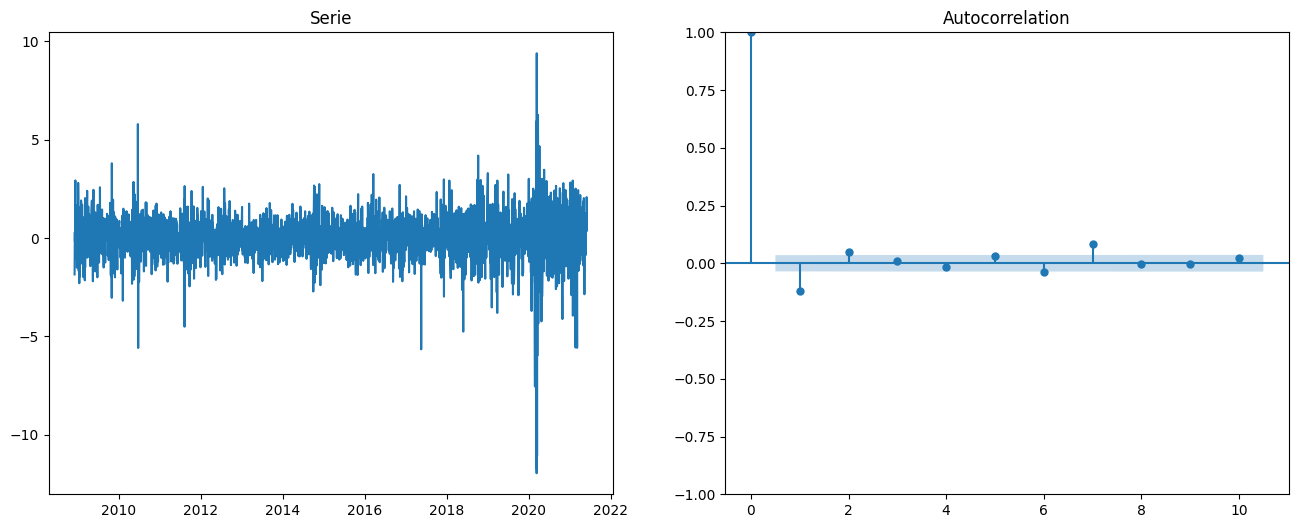

In [6]:
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(16,6))

diff = train.diff().dropna()
ax1.plot(diff)
ax1.set_title('Serie')

acf_plot = plot_acf(diff, lags=10, ax = ax2)


Podemos observar o gráfico da série diferenciada (esquerda) e o gráfico de autocorrelação (direita). Podemos observar que os valores 1, 2 e 7 tem uma correlação levemente superior ao nível de significância.

Para averiguar a necessidade de uma nova diferenciação, podemos reavaliar a estacionariedade da série através de um novo teste ADF.

In [7]:
print('ADF Test Statistics:', adfuller(diff)[0])
print('ADF P-value:', adfuller(diff)[1])

ADF Test Statistics: -9.327679520023867
ADF P-value: 9.513023218207291e-16


Nesse caso, o p-valor do teste foi muito próximo de 0, e portanto, é possível rejeitar a hipótese nula de que a série possui raiz unitária, e podemos afirmar que ela é uma série estacionária.

Nesse caso, foi necessário realizar apenas uma diferenciação para que a série se torne estacionária e, por isso, podemos concluir que *d = 1*

## Modelo Autorregressor

Para o termo *p*, precisamos identificar a ordem do modelo autorregressor. Ou seja, é preciso identificar quantos dados passados influenciam no valor presente.

Essa analise pode ser feita utilizando a função de autocorrelação parcial, como mostra o gráfico abaixo.

/home/matheus/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


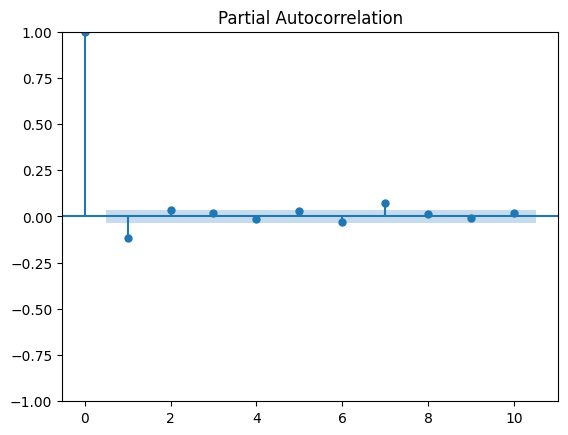

In [8]:
plot_pacf(diff, lags=10);

Podemos observar que os termos 1, 2 e 7 possuem uma autocorrelação parcial superior ao limite. Nesse caso, optei por usar apenas a ordem 2 (*p*=2)

## Termo q

Diferentemente do caso anterior, para identificar o termo q, devemos analisar a função de autocorrelação (ACF).

Assim como no caso anterior, o gráfico abaixo possui os termos 1, 2, 3 e 7 com uma correlação superior ao limite. Sendo assim, optei por usar *q* = 3.

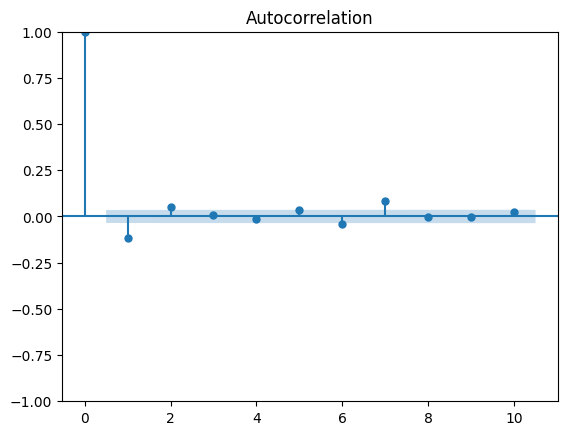

In [202]:
plot_acf(diff, lags=10);

## Modelagem e teste

In [203]:
model = ARIMA(train, order = (2,1,3))
result = model.fit()

/home/matheus/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/matheus/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/matheus/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/matheus/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationar

In [204]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3101
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -4697.665
Date:                Thu, 20 Oct 2022   AIC                           9407.331
Time:                        21:08:21   BIC                           9443.566
Sample:                             0   HQIC                          9420.343
                               - 3101                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0792      2.008     -0.039      0.969      -4.015       3.857
ar.L2         -0.0657      0.268     -0.245      0.807      -0.592       0.460
ma.L1         -0.0351      2.011     -0.017      0.9

Após a modelagem, podemos observar no sumário do teste que não temos nenhum coeficiente muito próximo de 0 e o p-valor de todos eles são 0. Isso mostra que todos os coeficientes encontrados são significantes.

Text(0, 0.5, 'Price')

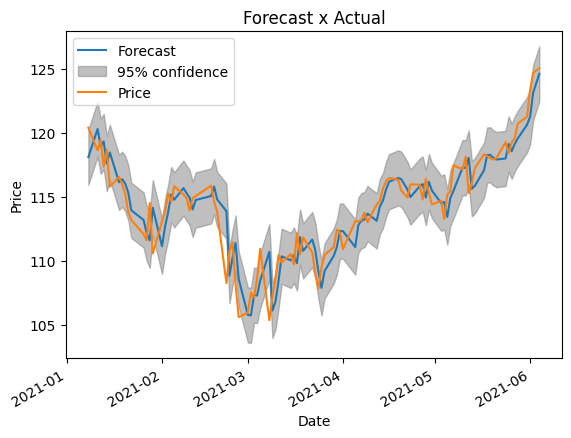

In [215]:
plot_predict(result, start = -100, end=-1, dynamic=False)
plt.plot(train[-100:])
plt.legend(['Forecast', '95% confidence', 'Price'])
plt.title('Forecast x Actual')
plt.ylabel('Price')

O gráfico acima traz um comparativo entre o modelo e o preço real do ETF ao longo do primeiro semestre de 2021. A previsões são atualizadas a medida que novas informações são incorporadas. Na maior parte do tempo a série se comportou dentro do intervalo de 95% de confiança definido pelo modelo.

Além disso, também usei a base de dados de teste para realizar uma projeção com dados não usados no treinamento do modelo e para um prazo maior.

/home/matheus/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/matheus/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Text(0, 0.5, 'Price')

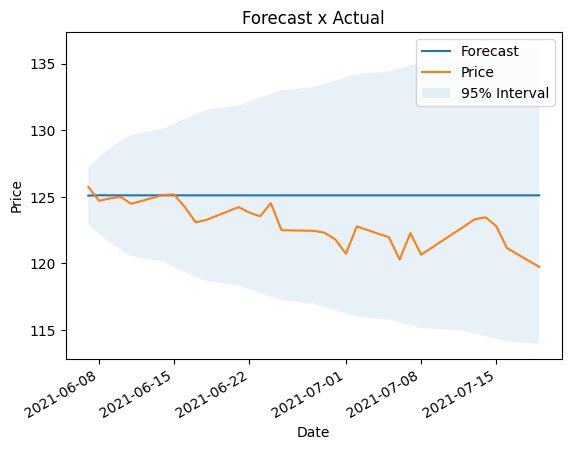

In [206]:
r = pd.DataFrame(data = result.forecast(30).values, index = test.index[:30])

forecast = result.get_forecast(30).conf_int(0.05)
forecast.index = test.index[:30]
forecast

r.plot()
test[:30].plot()
plt.fill_between(x= forecast.index, y1 = forecast['upper Close'],y2= forecast['lower Close'], alpha=.1)
plt.legend(['Forecast', 'Price', '95% Interval'])
plt.title('Forecast x Actual')
plt.ylabel('Price')

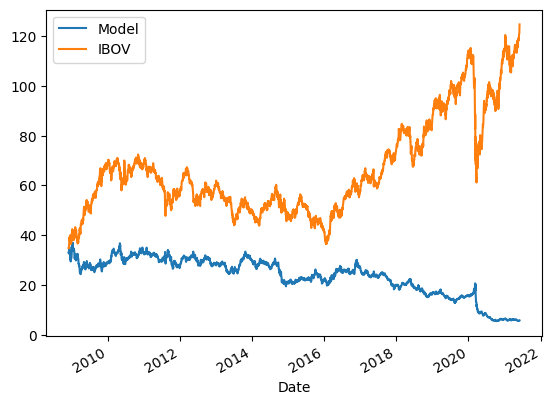

In [185]:
comparative = pd.DataFrame(data = result.predict()).join(train)
comparative.columns = ['predicted', 'real']
comparative['delta'] = comparative.real.shift(1) - comparative.predicted
comparative['var_real'] = comparative.real.pct_change()
comparative['model'] = np.where(comparative.delta >0,comparative.var_real,comparative.var_real*-1)
comparative=comparative[1:-1]

comparative.loc['2008-12-01','model'] = comparative.loc['2008-12-01','real'] *\
     (1+comparative.loc['2008-12-01','model'] )

comparative.model[1:] = comparative.model[1:]+1

comparative.model.cumprod().plot()
plt.plot(comparative.real)
plt.legend(['Model', 'IBOV'])

## Conclusão

É possível observar que o modelo 